In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import ttest_rel
import gc
import matplotlib.ticker as mticker
import os
import shap
from glob import glob
import numba
import xgboost as xgb
import shap
from statsmodels.api import add_constant
numba.set_num_threads(8)
import utils
import importlib
importlib.reload(utils)

<module 'utils' from 'D:\\Master Thesis\\Code\\codes - clean\\utils.py'>

In [2]:
ff_data = pd.read_csv('data/ff5_data_daily.csv')
ff_data['date'] = pd.to_datetime(ff_data['date'].astype(str), format='%Y%m%d')
ff_data.set_index('date', inplace=True)
amalgam_top_daily = pd.read_csv('data/Amalgam_Daily_Returns.csv', parse_dates=['date'], index_col='date')
amalgam_bottom_daily = pd.read_csv('data/Amalgam_Bottom_Daily_Returns.csv', parse_dates=['date'], index_col='date')
amalgam_tmb_daily = pd.read_csv('data/Amalgam_TopMinusBottom_Daily_Returns.csv', parse_dates=['date'], index_col='date')
index_data_daily = pd.read_csv('data/index_daily_returns.csv', parse_dates=['date'], dayfirst=True, index_col='date')
index_data_daily.index = pd.to_datetime(index_data_daily.index)
testset = pd.read_csv("data/Amalgam_Top_Predictions.csv")
df = pd.read_csv('data_merged_pctfluidshiftpct.csv')
firm_data_daily = pd.read_csv('data/firm_daily_returns_cleaned.csv', low_memory=False)

### Top Decile Position Sizing and Turnover

D:\Master Thesis\Code\codes - clean\DMT 2\Assignment 2\joblib_temp\ipykernel_1956\4195055480.py:2: FutureWarning: Constructing PeriodIndex from fields is deprecated. Use PeriodIndex.from_fields instead.
  testset['qtr_label'] = pd.PeriodIndex(year=testset['y'], quarter=testset['qtr'], freq='Q')


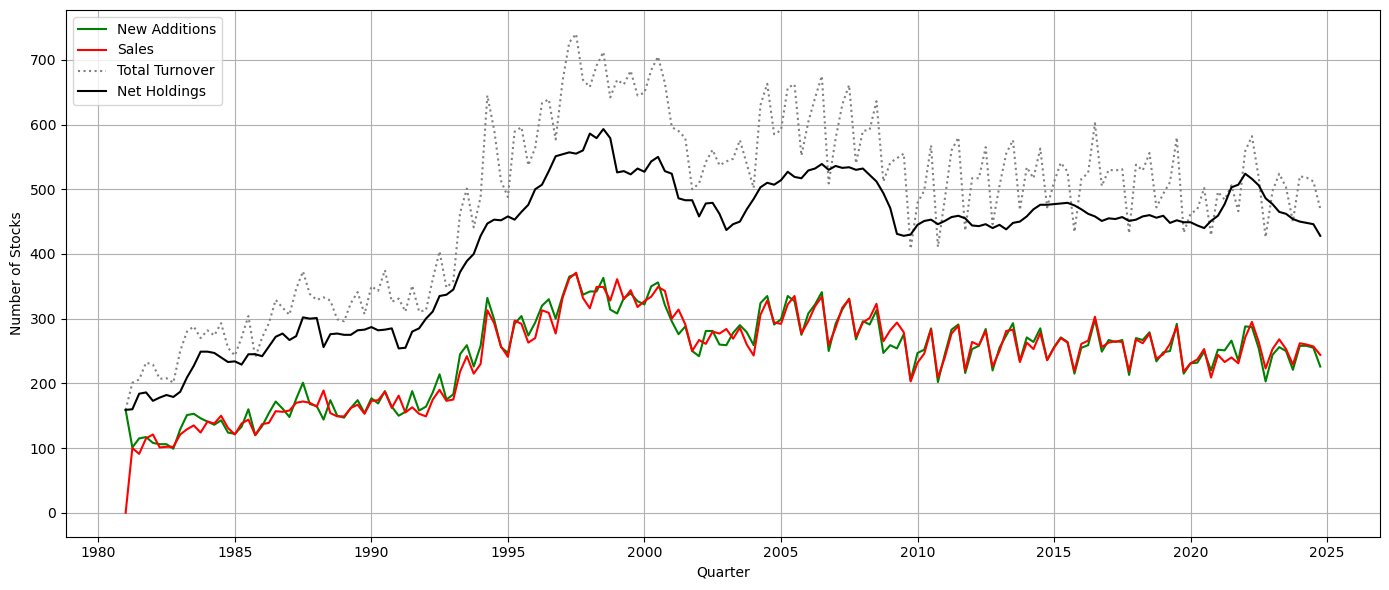

In [4]:
testset['qtr_label'] = pd.PeriodIndex(year=testset['y'], quarter=testset['qtr'], freq='Q')
testset = testset.sort_values(['qtr_label', 'prob'], ascending=[True, False])
valid_permnos = firm_data_daily['PERMNO'].unique()
testset = testset[testset['PERMNO'].isin(valid_permnos)]

# Rank predicted probabilities within each quarter
testset['rank'] = testset.groupby('qtr_label')['prob'].rank(method='first', ascending=False)

# Top decile selection
testset_top = testset[testset['rank'] <= testset.groupby('qtr_label')['rank'].transform('count') / 10]

portfolios = testset_top.groupby('qtr_label')['PERMNO'].apply(set).reset_index()

# Calculate turnover between successive quarters
portfolio_stats = []

for i in range(1, len(portfolios)):
    qtr_now = portfolios.loc[i, 'qtr_label']
    qtr_prev = portfolios.loc[i - 1, 'qtr_label']
    
    current_set = portfolios.loc[i, 'PERMNO']
    previous_set = portfolios.loc[i - 1, 'PERMNO']
    
    buys = current_set - previous_set
    sells = previous_set - current_set
    total_turnover = len(buys | sells)
    turnover_ratio = total_turnover / len(current_set)
    
    portfolio_stats.append({
        'quarter': qtr_now,
        'buys': len(buys),
        'sells': len(sells),
        'total_turnover': total_turnover,
        'turnover_ratio': round(turnover_ratio, 4),
        'holdings_count': len(current_set)
    })

initial_qtr = portfolios.loc[0, 'qtr_label']
initial_permnos = portfolios.loc[0, 'PERMNO']
initial_entry = {
    'quarter': initial_qtr,
    'buys': len(initial_permnos),
    'sells': 0,
    'total_turnover': len(initial_permnos),
    'turnover_ratio': 1.0,
    'holdings_count': len(initial_permnos)
}
portfolio_stats.insert(0, initial_entry)

portfolio_df = pd.DataFrame(portfolio_stats)
portfolio_df['quarter'] = portfolio_df['quarter'].dt.to_timestamp()

#Plot Buys, Sells, Total Turnover, and Holdings Count
plt.figure(figsize=(14, 6))
plt.plot(portfolio_df['quarter'], portfolio_df['buys'], color='green', label='New Additions')
plt.plot(portfolio_df['quarter'], portfolio_df['sells'], color='red', label='Sales')
plt.plot(portfolio_df['quarter'], portfolio_df['total_turnover'], color='grey', linestyle='dotted', label='Total Turnover')
plt.plot(portfolio_df['quarter'], portfolio_df['holdings_count'], color='black', label='Net Holdings')  

plt.xlabel("Quarter")
plt.ylabel("Number of Stocks")
plt.legend(loc='upper left')
plt.grid(True)
plt.tight_layout()
plt.show()

In [5]:
portfolio_df

,quarter,buys,sells,total_turnover,turnover_ratio,holdings_count
0,1981-01-01,159,0,159,1.0000,159
1,1981-04-01,101,100,201,1.2563,160
2,1981-07-01,115,91,206,1.1196,184
3,1981-10-01,117,115,232,1.2473,186
4,1982-01-01,108,121,229,1.3237,173
...,...,...,...,...,...,...
171,2023-10-01,221,229,450,0.9912,454
172,2024-01-01,258,262,520,1.1556,450
173,2024-04-01,258,260,518,1.1562,448
174,2024-07-01,255,257,512,1.1480,446


### Quarterly Trading Costs

D:\Master Thesis\Code\codes - clean\DMT 2\Assignment 2\joblib_temp\ipykernel_1956\3833345987.py:1: FutureWarning: Constructing PeriodIndex from fields is deprecated. Use PeriodIndex.from_fields instead.
  df['qtr_label'] = pd.PeriodIndex(year=df['y'], quarter=df['qtr'], freq='Q')


     quarter  buys  sells  total_turnover  holdings_count  avg_cost_per_trade  \
0 1981-01-01   159      0             159             159            0.000013   
1 1981-04-01   101    100             201             160            0.000013   
2 1981-07-01   115     91             206             184            0.000011   
3 1981-10-01   117    115             232             186            0.000011   
4 1982-01-01   108    121             229             173            0.000012   

   total_cost  
0    0.002000  
1    0.002438  
2    0.002174  
3    0.002462  
4    0.002543  


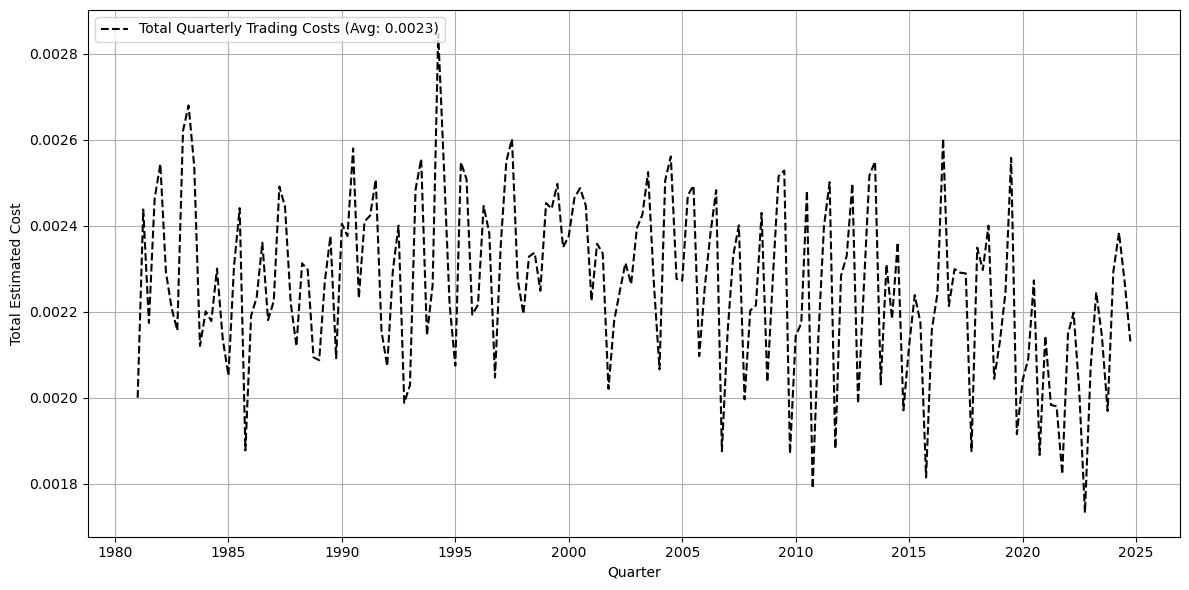

In [7]:
df['qtr_label'] = pd.PeriodIndex(year=df['y'], quarter=df['qtr'], freq='Q')
df_subset = df[['qtr_label', 'PERMNO', 'MC']]

alpha = 0.0020   # 20 bps
beta1 = 0.0025   # 25 bps
portfolio_df = portfolio_df.set_index('quarter') 

#Calculate trading costs 
cost_stats = []

for i in range(len(portfolios)):
    qtr_now = portfolios.loc[i, 'qtr_label']
    current_set = portfolios.loc[i, 'PERMNO']

    if i == 0:
        previous_set = set()
    else:
        previous_set = portfolios.loc[i - 1, 'PERMNO']

    traded_permnos = current_set.symmetric_difference(previous_set)

    holdings_count = len(current_set)
    equal_weight = 1 / holdings_count if holdings_count > 0 else 0

    mc_data = df_subset[df_subset['qtr_label'] == qtr_now]
    mc_trades = mc_data[mc_data['PERMNO'].isin(traded_permnos)].copy()
    mc_trades = mc_trades.dropna(subset=['MC'])

    # Apply Avramov cost function
    mc_trades['weighted_cost'] = equal_weight * (alpha + beta1 * (equal_weight / (mc_trades['MC'] * 1_000_000)))
    total_cost = mc_trades['weighted_cost'].sum()
    avg_cost = mc_trades['weighted_cost'].mean()

    cost_stats.append({
        'quarter': qtr_now.to_timestamp(),
        'buys': len(current_set - previous_set),
        'sells': len(previous_set - current_set),
        'total_turnover': len(traded_permnos),
        'holdings_count': holdings_count,
        'avg_cost_per_trade': avg_cost,
        'total_cost': total_cost
    })
    
cost_df = pd.DataFrame(cost_stats)
print(cost_df.head())
avg_total_cost = cost_df['total_cost'].mean()

plt.figure(figsize=(12, 6))
plt.plot(cost_df['quarter'], cost_df['total_cost'],
         label=f'Total Quarterly Trading Costs (Avg: {avg_total_cost:.4f})',
         color='black', linestyle='dashed')

plt.xlabel('Quarter')
plt.ylabel('Total Estimated Cost')
plt.grid(True)
plt.tight_layout()
plt.legend(loc='upper left')
plt.show()

### Get Returns Net of Trading Costs; all 'RET' codes for the top decile can be substituted with 'RET_net' in subsequent code chunks to inspect the impact

In [9]:
amalgam_top_daily = amalgam_top_daily.sort_index()

amalgam_top_daily['qtr_label'] = amalgam_top_daily.index.to_period('Q')

first_day_map = amalgam_top_daily.reset_index().groupby('qtr_label')['date'].first().to_dict()


cost_df['qtr_label'] = cost_df['quarter'].dt.to_period('Q')
cost_df['deduct_day'] = cost_df['qtr_label'].map(first_day_map)

cost_series = pd.Series(0.0, index=amalgam_top_daily.index, dtype=float)
cost_series.update(cost_df.set_index('deduct_day')['total_cost'])

# === Subtract trading costs on first day of each quarter ===
amalgam_top_daily['RET_net'] = amalgam_top_daily['RET'] - cost_series

# === (Optional) Save or inspect ===
print(amalgam_top_daily[['RET', 'RET_net']].head(10))

                 RET   RET_net
date                          
1981-01-02  0.006168  0.004168
1981-01-05  0.007659  0.007659
1981-01-06 -0.006750 -0.006750
1981-01-07 -0.038481 -0.038481
1981-01-08 -0.010592 -0.010592
1981-01-09  0.006594  0.006594
1981-01-12  0.005913  0.005913
1981-01-13 -0.001618 -0.001618
1981-01-14  0.008616  0.008616
1981-01-15  0.007819  0.007819


D:\Master Thesis\Code\codes - clean\DMT 2\Assignment 2\joblib_temp\ipykernel_1956\2469618327.py:2: FutureWarning: Constructing PeriodIndex from fields is deprecated. Use PeriodIndex.from_fields instead.
  df['qtr_label'] = pd.PeriodIndex(year=df['y'], quarter=df['qtr'], freq='Q')


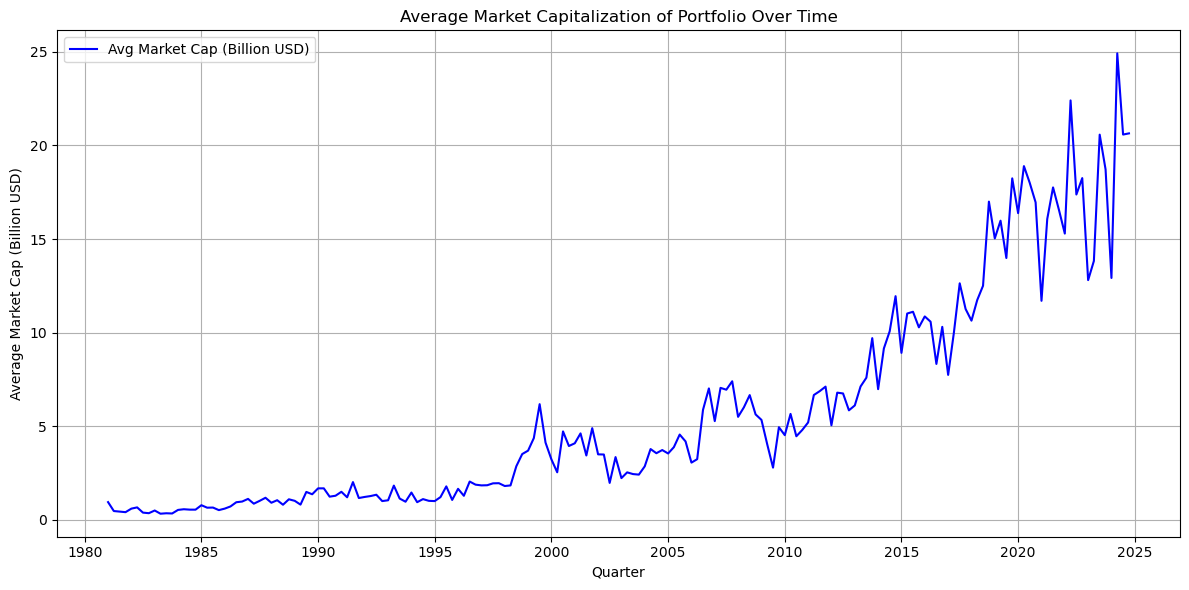

In [10]:
df['qtr_label'] = pd.PeriodIndex(year=df['y'], quarter=df['qtr'], freq='Q')
df_subset = df[['qtr_label', 'PERMNO', 'MC']].dropna()

avg_mc_stats = []

for i in range(len(portfolios)):
    qtr_now = portfolios.loc[i, 'qtr_label']
    current_permnos = portfolios.loc[i, 'PERMNO']

    mc_data = df_subset[(df_subset['qtr_label'] == qtr_now) &
                        (df_subset['PERMNO'].isin(current_permnos))]

    avg_mc = (mc_data['MC'].mean()) if not mc_data.empty else np.nan

    avg_mc_stats.append({
        'quarter': qtr_now.to_timestamp(),
        'avg_market_cap_musd': avg_mc,  # in millions USD
        'avg_market_cap_busd': avg_mc / 1_000 if pd.notnull(avg_mc) else np.nan  # in billions USD
    })

avg_mc_df = pd.DataFrame(avg_mc_stats)

# Plot
plt.figure(figsize=(12, 6))
plt.plot(avg_mc_df['quarter'], avg_mc_df['avg_market_cap_busd'],
         color='blue', label='Avg Market Cap (Billion USD)')

plt.xlabel("Quarter")
plt.ylabel("Average Market Cap (Billion USD)")
plt.title("Average Market Capitalization of Portfolio Over Time")
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()

#### High Level View Chart

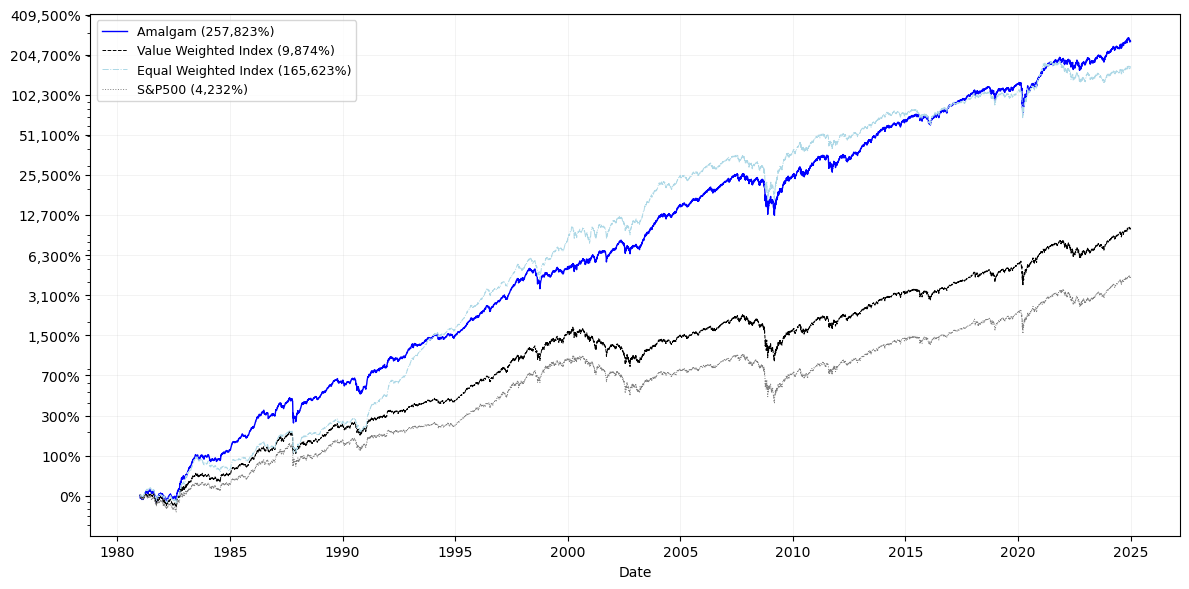

In [12]:
from utils import get_cum_returns

returns = pd.DataFrame({
    'Amalgam': amalgam_top_daily['RET_net'],
    'Value Weighted Index': index_data_daily['vwretd'],
    'Equal Weighted Index': index_data_daily['ewretd'],
    'S&P500': index_data_daily['sprtrn']
}).dropna()

# Calculate cumulative returns
cum_returns = get_cum_returns(returns)

final_labels = {
    col: f"{col} ({(cum_returns[col].iloc[-1] - 1) * 100:,.0f}%)"
    for col in cum_returns.columns
}

fig, ax = plt.subplots(1, 1, figsize=(12, 6))
ax.plot(cum_returns.index, cum_returns['Amalgam'], label=final_labels['Amalgam'], color='blue', linewidth=1)
ax.plot(cum_returns.index, cum_returns['Value Weighted Index'], label=final_labels['Value Weighted Index'], color='black', linewidth=0.7, linestyle='--')
ax.plot(cum_returns.index, cum_returns['Equal Weighted Index'], label=final_labels['Equal Weighted Index'], color='lightblue', linewidth=0.7, linestyle='-.')
ax.plot(cum_returns.index, cum_returns['S&P500'], label=final_labels['S&P500'], color='grey', linewidth=0.7, linestyle=':')

# Log scale with dynamic percentage formatting
ax.set_yscale('log')

def comma_percent(x, pos):
    if x <= 0:
        return ''
    pct = (x - 1) * 100
    return f"{pct:,.0f}%"

ax.yaxis.set_major_formatter(mticker.FuncFormatter(comma_percent))
ax.set_yticks([1, 2, 4, 8, 16, 32, 64, 128, 256, 512, 1024, 2048, 4096]) #8192, 16384, 32768, 65536, 131072]

ax.set_xlabel('Date')
#ax.set_title('Cumulative Returns Comparison: Amalgam Model vs Broad-Market Indices (Q1 1981 - Q4 2024)', fontsize=12)
ax.grid(True, linestyle='-', linewidth=0.5, alpha=0.2)
ax.legend(loc='upper left', fontsize=9)

plt.tight_layout()
plt.show()

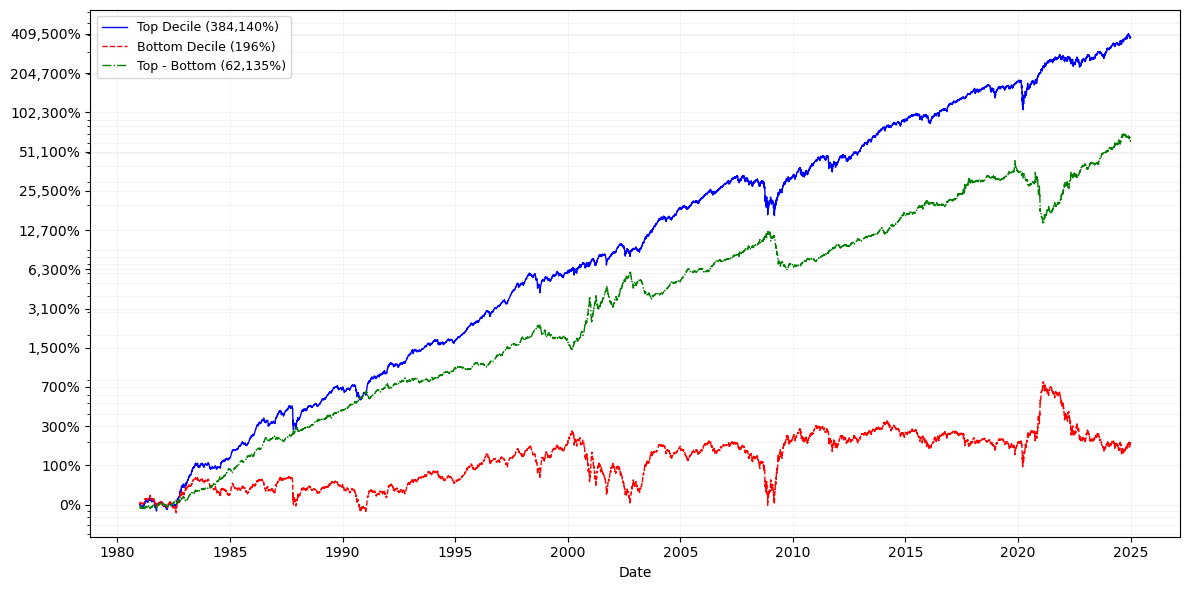

In [6]:
from utils import get_cum_returns

returns = pd.DataFrame({
    'Top Decile': amalgam_top_daily['RET'],
    'Bottom Decile': amalgam_bottom_daily['RET'],
    'Top - Bottom': amalgam_tmb_daily['RET']
}).dropna()

cum_returns = get_cum_returns(returns)

final_labels = {
    col: f"{col} ({(cum_returns[col].iloc[-1] - 1) * 100:,.0f}%)"
    for col in cum_returns.columns
}

fig, ax = plt.subplots(figsize=(12, 6))
colors = {
    'Top Decile': 'blue',
    'Bottom Decile': 'red',
    'Top - Bottom': 'green'
}
linestyles = {
    'Top Decile': '-',
    'Bottom Decile': '--',
    'Top - Bottom': '-.'
}

for col in cum_returns.columns:
    ax.plot(
        cum_returns.index,
        cum_returns[col],
        label=final_labels[col],
        color=colors[col],
        linestyle=linestyles[col],
        linewidth=1
    )

ax.set_yscale('log')

def comma_percent(x, pos):
    if x <= 0:
        return ''
    pct = (x - 1) * 100
    return f"{pct:,.0f}%"

ax.yaxis.set_major_formatter(mticker.FuncFormatter(comma_percent))
ax.set_yticks([1, 2, 4, 8, 16, 32, 64, 128, 256, 512, 1024, 2048, 4096]) #8192, 16384, 32768, 65536, 131072]
ax.set_xlabel("Date")
#ax.set_title("Cumulative Returns: Top vs Bottom Decile", fontsize=12)
ax.legend(loc='upper left', fontsize=9)
ax.grid(True, which='both', linestyle='-', linewidth=0.5, alpha=0.2)
plt.tight_layout()
plt.show()

### Total Period FF5 Regression of 90th percentile, 10th percentile and 90th minus 10th

In [14]:
import utils

amalgam_top_daily.index = pd.to_datetime(amalgam_top_daily.index)
amalgam_bottom_daily.index = pd.to_datetime(amalgam_bottom_daily.index)
amalgam_tmb_daily.index = pd.to_datetime(amalgam_tmb_daily.index)
ff_data.index = pd.to_datetime(ff_data.index)

aligned_top = pd.DataFrame({'ret': amalgam_top_daily['RET_net']}).join(ff_data, how='left').dropna()
aligned_bottom = pd.DataFrame({'ret': amalgam_bottom_daily['RET']}).join(ff_data, how='left').dropna()
aligned_tmb = pd.DataFrame({'ret': amalgam_tmb_daily['RET']}).join(ff_data, how='left').dropna()

years_top = aligned_top.index[-1].year - aligned_top.index[0].year + 1
years_bottom = aligned_bottom.index[-1].year - aligned_bottom.index[0].year + 1
years_tmb = aligned_tmb.index[-1].year - aligned_tmb.index[0].year + 1

amalgam_ff = pd.DataFrame()
amalgam_ff['Amalgam Top'] = utils.regress_ff5mom(aligned_top['ret'], aligned_top, years=years_top)
amalgam_ff['Amalgam Bottom'] = utils.regress_ff5mom(aligned_bottom['ret'], aligned_bottom, years=years_bottom)
amalgam_ff['Top - Bottom'] = utils.regress_ff5mom(aligned_tmb['ret'], aligned_tmb, leverage=0, years=years_tmb)

replacements = {'const': 'alpha', 'mktrf': 'RMRF', 'smb': 'SMB', 'hml': 'HML', 'rmw': 'RMW', 'cma': 'CMA', 'umd': 'MOM'}
amalgam_ff.index = [replacements.get(idx, idx) for idx in amalgam_ff.index]

amalgam_ff.to_excel('results/amalgam_ff.xlsx')

### Post 2020 Period FF5 Regression of 90th percentile, 10th percentile and 90th minus 10th

In [15]:
import utils

amalgam_top_daily.index = pd.to_datetime(amalgam_top_daily.index)
amalgam_bottom_daily.index = pd.to_datetime(amalgam_bottom_daily.index)
amalgam_tmb_daily.index = pd.to_datetime(amalgam_tmb_daily.index)
ff_data.index = pd.to_datetime(ff_data.index)

# Filter to post-2020
amalgam_top_post2020 = amalgam_top_daily[amalgam_top_daily.index >= '2020-01-01']
amalgam_bottom_post2020 = amalgam_bottom_daily[amalgam_bottom_daily.index >= '2020-01-01']
amalgam_tmb_post2020 = amalgam_tmb_daily[amalgam_tmb_daily.index >= '2020-01-01']
ff_post2020 = ff_data[ff_data.index >= '2020-01-01']

aligned_top = pd.DataFrame({'ret': amalgam_top_post2020['RET_net']}).join(ff_post2020, how='left').dropna()
aligned_bottom = pd.DataFrame({'ret': amalgam_bottom_post2020['RET']}).join(ff_post2020, how='left').dropna()
aligned_tmb = pd.DataFrame({'ret': amalgam_tmb_post2020['RET']}).join(ff_post2020, how='left').dropna()

years_top = aligned_top.index[-1].year - aligned_top.index[0].year + 1
years_bottom = aligned_bottom.index[-1].year - aligned_bottom.index[0].year + 1
years_tmb = aligned_tmb.index[-1].year - aligned_tmb.index[0].year + 1

# Run regressions
amalgam_ff_post2020 = pd.DataFrame()
amalgam_ff_post2020['Amalgam Top'] = utils.regress_ff5mom(aligned_top['ret'], aligned_top, years=years_top)
amalgam_ff_post2020['Amalgam Bottom'] = utils.regress_ff5mom(aligned_bottom['ret'], aligned_bottom, years=years_bottom)
amalgam_ff_post2020['Top - Bottom'] = utils.regress_ff5mom(aligned_tmb['ret'], aligned_tmb, leverage=0, years=years_tmb)

replacements = {'const': 'alpha', 'mktrf': 'RMRF', 'smb': 'SMB', 'hml': 'HML', 'rmw': 'RMW', 'cma': 'CMA', 'umd': 'MOM'}
amalgam_ff_post2020.index = [replacements.get(idx, idx) for idx in amalgam_ff_post2020.index]

amalgam_ff_post2020.to_excel('results/amalgam_ff_post2020.xlsx')

### Total OOS Period Metrics

In [16]:
from utils import evaluate_returns, get_max_drawdown

amalgam_top_daily.index = pd.to_datetime(amalgam_top_daily.index)
index_data_daily.index = pd.to_datetime(index_data_daily.index)
ff_data.index = pd.to_datetime(ff_data.index)

returns = pd.DataFrame({
    'Amalgam': amalgam_top_daily['RET_net'],
    'Value Weighted Index': index_data_daily['vwretd'],
    'Equal Weighted Index': index_data_daily['ewretd'],
    'S&P500': index_data_daily['sprtrn']
}).dropna()

rf = ff_data['rf'] if 'rf' in ff_data.columns else pd.Series(0, index=returns.index)
rf = rf.reindex(returns.index).fillna(0)

perf_table = pd.DataFrame()
for col in returns.columns:
    aligned_rf = rf.reindex(returns[col].index).fillna(0)
    n_years = returns[col].index[-1].year - returns[col].index[0].year + 1
    perf_table[col] = evaluate_returns(returns[col], aligned_rf, years=n_years)

perf_table

,Amalgam,Value Weighted Index,Equal Weighted Index,S&P500
CAGR,19.55%,11.03%,18.35%,8.94%
Standard deviation,0.1627,0.1725,0.1488,0.1787
Sharpe ratio,0.9468,0.4736,0.9527,0.3574
Maximum drawdown,51.25%,55.52%,55.11%,56.78%


#### Full Period T-test for Risk Adjusted Daily Returns

In [19]:
from utils import regress_ff5mom, ttest_risk_adj

returns = pd.DataFrame({
    'Amalgam': amalgam_top_daily['RET'],
    'Value Weighted Index': index_data_daily['vwretd'],
    'Equal Weighted Index': index_data_daily['ewretd'],
    'S&P500': index_data_daily['sprtrn']
}).dropna()

common_index = returns.index.intersection(ff_data.index)
returns = returns.loc[common_index]
ff_data = ff_data.loc[common_index]

# Run FF5+MOM regression for each
ff_results_full = pd.DataFrame()
for col in returns.columns:
    ff_results_full[col] = regress_ff5mom(returns[col], ff_data)
ff_results_full = ff_results_full.T

replacements = {'const': 'alpha', 'mktrf': 'RMRF', 'smb': 'SMB', 'hml': 'HML', 'rmw': 'RMW', 'cma': 'CMA', 'umd': 'MOM'}
ff_results_full.columns = [next((col.replace(k, v) for k, v in replacements.items() if k in col), col) for col in ff_results_full.columns]

# T-tests for difference in alpha (Amalgam vs. benchmark)
ttest_results_full = pd.DataFrame()
rf = ff_data['rf']
amalgam_excess = returns['Amalgam'] - rf
for col in ['Equal Weighted Index', 'Value Weighted Index', 'S&P500']:
    bench_excess = returns[col] - rf
    ttest_results_full[col] = ttest_risk_adj(amalgam_excess, bench_excess, rf)
ttest_results_full = ttest_results_full.T.round(3)

ff_results_full[['alpha']]
ttest_results_full

,0,1
Equal Weighted Index,1.593,0.056
Value Weighted Index,8.934,0.000
S&P500,8.597,0.000


### Post 2020 OOS Period Metrics

In [17]:
returns_post2010 = returns[returns.index >= '2020-01-01']
rf_post2010 = rf.reindex(returns_post2010.index).fillna(0)

perf_table_post2010 = pd.DataFrame()
for col in returns_post2010.columns:
    aligned_rf = rf_post2010.reindex(returns_post2010[col].index).fillna(0)
    n_years = returns_post2010[col].index[-1].year - returns_post2010[col].index[0].year + 1
    perf_table_post2010[col] = evaluate_returns(returns_post2010[col], aligned_rf, years=n_years)

perf_table_post2010

,Amalgam,Value Weighted Index,Equal Weighted Index,S&P500
CAGR,15.73%,12.65%,8.78%,12.73%
Standard deviation,0.2269,0.2111,0.2115,0.2132
Sharpe ratio,0.6551,0.5596,0.3940,0.5594
Maximum drawdown,40.70%,34.67%,38.53%,33.93%


In [47]:
returns = pd.DataFrame({
    'Amalgam': amalgam_top_daily['RET'],
    'Value Weighted Index': index_data_daily['vwretd'],
    'Equal Weighted Index': index_data_daily['ewretd'],
    'S&P500': index_data_daily['sprtrn']
}).dropna()

returns_post2020 = returns[returns.index >= '2020-01-01']

def get_cum_returns(df):
    return (1 + df).cumprod()

cum_returns = get_cum_returns(returns_post2020)

final_cumrets = cum_returns.iloc[-1] - 1
cumret_table = final_cumrets.to_frame(name='Cumulative Return (%)')
cumret_table['Cumulative Return (%)'] = (cumret_table['Cumulative Return (%)'] * 100).round(2)

cumret_table

,Cumulative Return (%)
Amalgam,116.47
Value Weighted Index,81.41
Equal Weighted Index,52.34
S&P500,82.05


#### Post 2020 T-test for Risk Adjusted Daily Returns

In [28]:
import pandas as pd
from utils import regress_ff5mom, ttest_risk_adj

returns = pd.DataFrame({
    'Amalgam': amalgam_top_daily['RET'],
    'Value Weighted Index': index_data_daily['vwretd'],
    'Equal Weighted Index': index_data_daily['ewretd'],
    'S&P500': index_data_daily['sprtrn']
}).dropna()

# Filter from 2020 onward and align with FF data
returns_post2020 = returns[returns.index >= '2020-01-01']
ff_data_post2020 = ff_data[ff_data.index >= '2020-01-01']
common_index = returns_post2020.index.intersection(ff_data_post2020.index)
returns = returns_post2020.loc[common_index]
ff_data = ff_data_post2020.loc[common_index]

ff_results = pd.DataFrame()
for col in returns.columns:
    ff_results[col] = regress_ff5mom(returns[col], ff_data)
ff_results = ff_results.T

replacements = {'const': 'alpha', 'mktrf': 'RMRF', 'smb': 'SMB', 'hml': 'HML', 'rmw': 'RMW', 'cma': 'CMA', 'umd': 'MOM'}
ff_results.columns = [next((col.replace(k, v) for k, v in replacements.items() if k in col), col) for col in ff_results.columns]

# T-tests for difference in alpha (Amalgam vs. benchmark)
ttest_results = pd.DataFrame()
rf = ff_data['rf']
amalgam_excess = returns['Amalgam'] - rf
for col in ['Equal Weighted Index', 'Value Weighted Index', 'S&P500']:
    bench_excess = returns[col] - rf
    ttest_results[col] = ttest_risk_adj(amalgam_excess, bench_excess, rf)
ttest_results = ttest_results.T.round(3)

ff_results[['alpha']]
ttest_results

,0,1
Equal Weighted Index,2.415,0.008
Value Weighted Index,0.835,0.202
S&P500,0.693,0.244


#### Shap Values

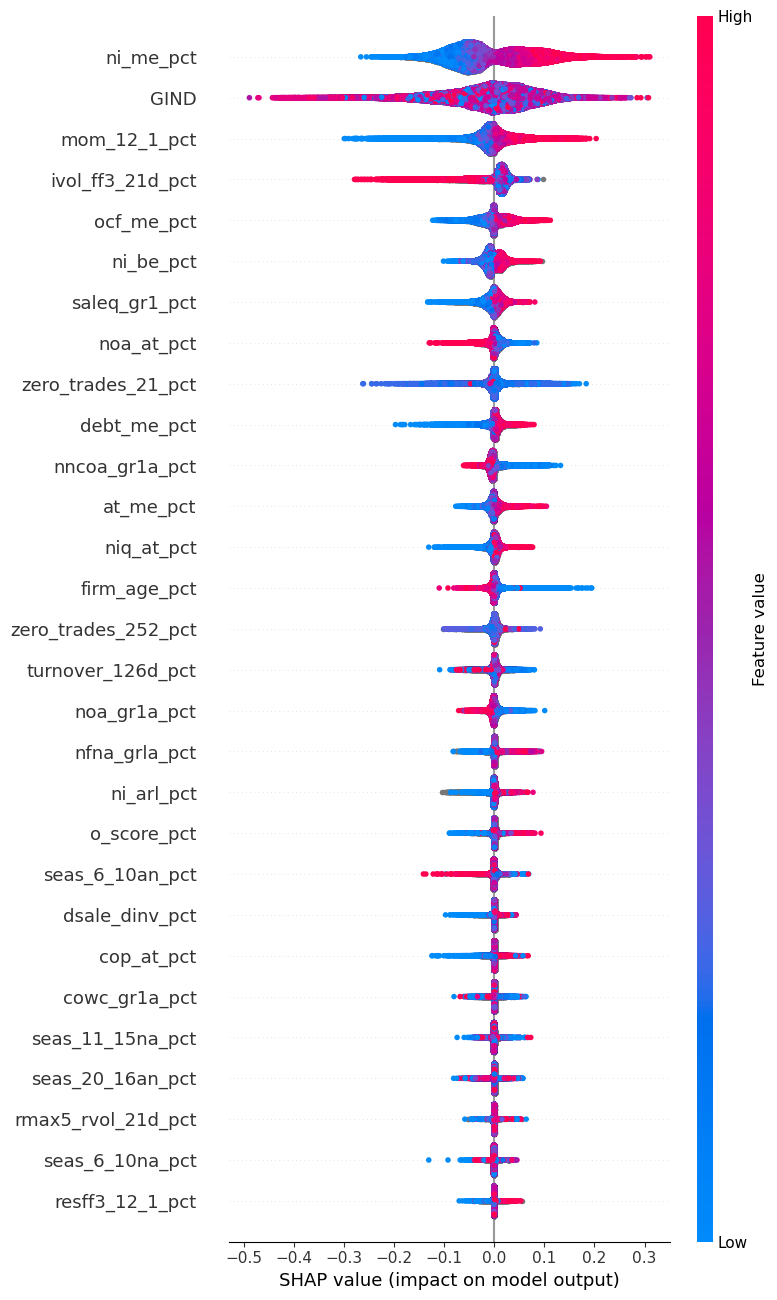

In [31]:
import shap
import xgboost as xgb
import numpy as np
import pandas as pd
import os

model_dir = "models/amalgam_xgb_roll"
testset = pd.read_csv("data/Amalgam_Top_Predictions.csv")

# Load all models
models = {}
for fname in sorted(os.listdir(model_dir)): 
    if fname.endswith(".json"):
        y, q = map(int, fname.replace("xgb_", "").replace(".json", "").split("_"))
        booster = xgb.Booster()
        booster.load_model(os.path.join(model_dir, fname))
        models[(y, q)] = booster

# Gather SHAP values and feature data
shap_vals_list = []
X_list = []

for (y, qtr), booster in models.items():
    test_q = testset[(testset['y'] == y) & (testset['qtr'] == qtr)].copy()
    if test_q.empty:
        continue

    feature_cols = [col for col in test_q.columns if col.endswith('_pct')] + ['GIND']
    X = test_q[feature_cols].copy()
    X['GIND'] = X['GIND'].astype("category")

    dmatrix = xgb.DMatrix(X, enable_categorical=True)
    explainer = shap.Explainer(booster)

    shap_values = explainer(dmatrix)

    shap_vals_list.append(shap_values.values)
    X_list.append(X)


all_shap_vals = np.vstack(shap_vals_list)
all_X = pd.concat(X_list, axis=0)
shap.summary_plot(all_shap_vals, all_X, max_display=29)

In [32]:
shap_summary_df = pd.DataFrame({
    'feature': all_X.columns,
    'mean_abs_shap_pct': np.abs(all_shap_vals).mean(axis=0) * 100,     # absolute contribution
    'mean_signed_shap_pct': all_shap_vals.mean(axis=0) * 100           # directional contribution
}).sort_values('mean_abs_shap_pct', ascending=False).reset_index(drop=True)

shap_summary_df.to_csv("results/shap_feature_summary_percent.csv", index=False)
shap_summary_df

,feature,mean_abs_shap_pct,mean_signed_shap_pct
0,ni_me_pct,6.527293,-0.556477
1,GIND,6.062164,-0.799781
2,mom_12_1_pct,2.536405,-0.094436
3,ivol_ff3_21d_pct,2.347722,0.041862
4,ocf_me_pct,1.875222,0.100646
5,ni_be_pct,1.244482,-0.132789
6,saleq_gr1_pct,1.134329,-0.102653
7,noa_at_pct,0.918857,-0.004476
8,zero_trades_21_pct,0.886259,0.043894
9,debt_me_pct,0.817864,-0.073091


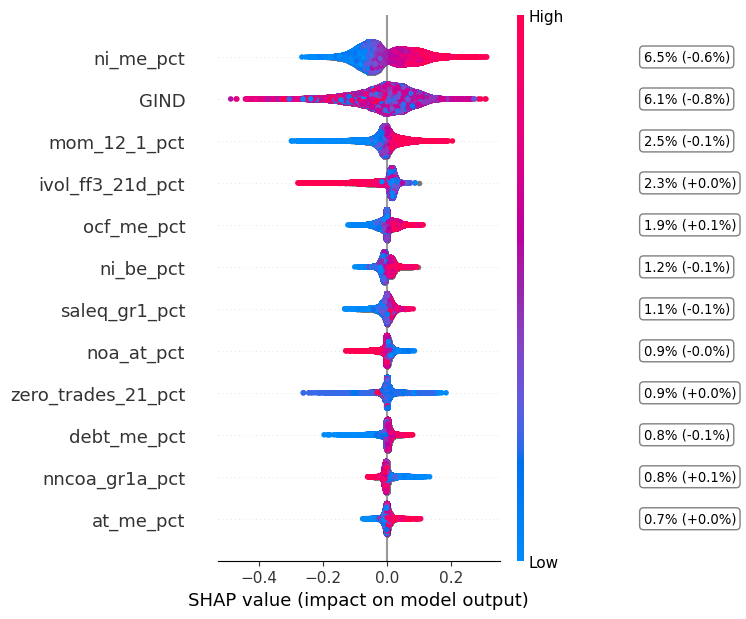

In [33]:
import shap
import xgboost as xgb
import numpy as np
import pandas as pd
import os
import matplotlib.pyplot as plt

model_dir = "models/amalgam_xgb_roll"
testset = pd.read_csv("data/Amalgam_Top_Predictions.csv")

models = {}
for fname in sorted(os.listdir(model_dir)):
    if fname.endswith(".json"):
        y, q = map(int, fname.replace("xgb_", "").replace(".json", "").split("_"))
        booster = xgb.Booster()
        booster.load_model(os.path.join(model_dir, fname))
        models[(y, q)] = booster

shap_vals_list = []
X_list = []

for (y, qtr), booster in models.items():
    test_q = testset[(testset['y'] == y) & (testset['qtr'] == qtr)].copy()
    if test_q.empty:
        continue

    feature_cols = [col for col in test_q.columns if col.endswith('_pct')] + ['GIND']
    X = test_q[feature_cols].copy()
    X['GIND'] = X['GIND'].astype("category")

    dmatrix = xgb.DMatrix(X, enable_categorical=True)
    explainer = shap.Explainer(booster)
    shap_values = explainer(dmatrix)

    shap_vals_list.append(shap_values.values)
    X_list.append(X)

all_shap_vals = np.vstack(shap_vals_list)
all_X = pd.concat(X_list, axis=0)

shap_summary_df = pd.DataFrame({
    'feature': all_X.columns,
    'mean_abs_shap_pct': np.abs(all_shap_vals).mean(axis=0) * 100,
    'mean_signed_shap_pct': all_shap_vals.mean(axis=0) * 100
})

shap_exp = shap.Explanation(
    values=all_shap_vals,
    data=all_X.values,
    feature_names=all_X.columns
)

mean_abs_shap = np.abs(all_shap_vals).mean(axis=0)
ordered_indices = np.argsort(mean_abs_shap)[::-1][:12]
ordered_feature_names = all_X.columns[ordered_indices]

plt.figure(figsize=(13, 12))
shap.summary_plot(all_shap_vals, all_X, max_display=12, show=False)
plt.gcf().axes[-1].set_ylabel("")

for i, feat in enumerate(ordered_feature_names):
    y_pos = len(ordered_feature_names) - 1 - i  
    abs_val = shap_summary_df.loc[shap_summary_df['feature'] == feat, 'mean_abs_shap_pct'].values[0]
    signed_val = shap_summary_df.loc[shap_summary_df['feature'] == feat, 'mean_signed_shap_pct'].values[0]

    plt.text(
        0.8, y_pos, f"{abs_val:.1f}% ({signed_val:+.1f}%)",
        verticalalignment='center',
        horizontalalignment='left',
        fontsize=9.5,
        bbox=dict(facecolor='white', edgecolor='gray', boxstyle='round,pad=0.3'),
        clip_on=False,
        transform=plt.gca().transData
    )

plt.tight_layout()
plt.savefig("results/shap_summary_annotated_rightside_fixed.png", dpi=300)
plt.show()

### Model Feature Importance Across the Decades

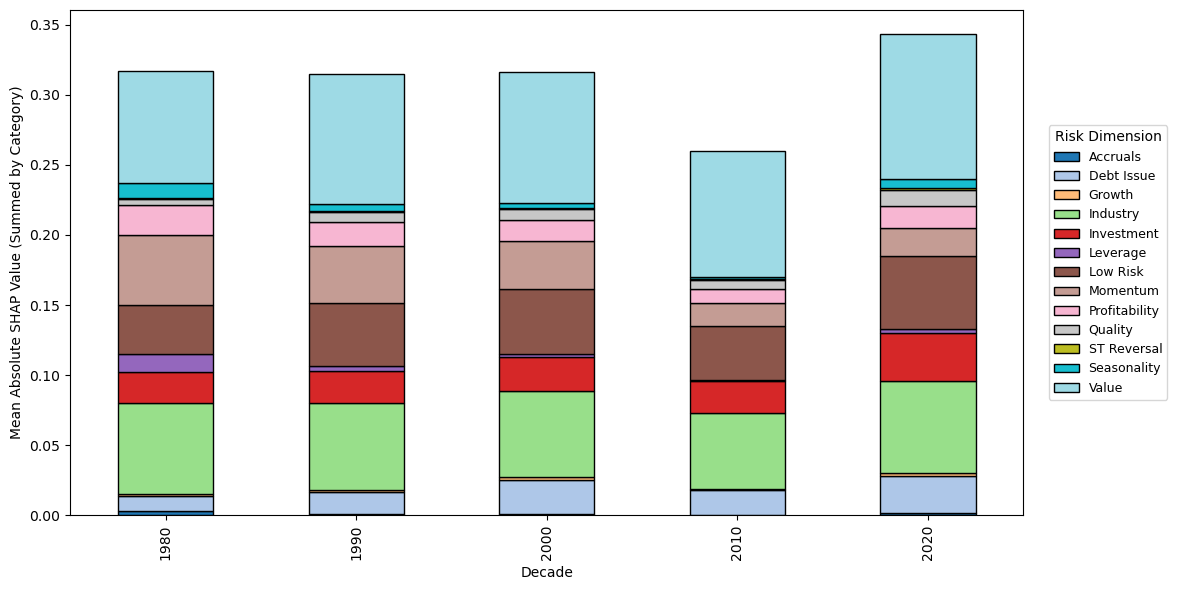

In [35]:
# Step 1: Clean feature names
feature_map = {
    'ni_me_pct': 'ni_me',
    'GIND': 'GIND',
    'mom_12_1_pct': 'ret_12_1',  
    'ivol_ff3_21d_pct': 'ivol_ff3_21d',
    'ocf_me_pct': 'ocf_me',
    'ni_be_pct': 'ni_be',
    'saleq_gr1_pct': 'saleq_gr1',
    'noa_at_pct': 'noa_at',
    'zero_trades_21_pct': 'zero_trades_21d',
    'debt_me_pct': 'debt_me',
    'nncoa_gr1a_pct': 'nncoa_gr1a',
    'at_me_pct': 'at_me',
    'niq_at_pct': 'niq_at',
    'firm_age_pct': 'age',
    'zero_trades_252_pct': 'zero_trades_252d',
    'turnover_126d_pct': 'turnover_126d',
    'noa_gr1a_pct': 'noa_gr1a',
    'nfna_grla_pct': 'nfna_grla',
    'ni_arl_pct': 'ni_arl',
    'o_score_pct': 'o_score',
    'seas_6_10an_pct': 'seas_6_10an',
    'dsale_dinv_pct': 'dsale_dinv',
    'cop_at_pct': 'cop_at',
    'cowc_gr1a_pct': 'cowc_gr1a',
    'seas_11_15na_pct': 'seas_11_15na',
    'seas_20_16an_pct': 'seas_16_20an',  
    'rmax5_rvol_21d_pct': 'rmax5_rvol_21d',
    'seas_6_10na_pct': 'seas_6_10na',
    'resff3_12_1_pct': 'resff3_12_1'
}


# Step 2: Feature-to-category map
category_map = {
    'cop_at': 'Quality', 'noa_gr1a': 'Investment', 'saleq_gr1': 'Investment',
    'resff3_12_1': 'Momentum', 'seas_6_10an': 'Seasonality', 'debt_me': 'Value',
    'seas_6_10na': 'Low Risk', 'zero_trades_252d': 'Low Risk', 'cowc_gr1a': 'Accruals',
    'nncoa_gr1a': 'Investment', 'ocf_me': 'Value', 'zero_trades_21d': 'Low Risk',
    'turnover_126d': 'Low Risk', 'rmax5_rvol_21d': 'ST Reversal', 'seas_11_15na': 'Seasonality',
    'o_score': 'Profitability', 'niq_at': 'Quality', 'seas_16_20an': 'Seasonality',
    'ni_arl': 'Debt Issue', 'ivol_ff3_21d': 'Low Risk', 'ni_me': 'Value',
    'dsale_dinv': 'Growth', 'ni_be': 'Profitability', 'noa_at': 'Debt Issue',
    'age': 'Momentum', 'ret_12_1': 'Momentum', 'nfna_grla': 'Leverage',
    'at_me': 'Debt Issue', 'GIND': 'Industry'
}

# Step 3: Attach year and rename features
years = pd.concat([pd.Series(y, index=X.index) for ((y, _), X) in zip(models.keys(), X_list)])
shap_long = pd.DataFrame(all_shap_vals, columns=all_X.columns)
shap_long['y'] = years.values
shap_long['decade'] = (shap_long['y'] // 10) * 10
shap_long = shap_long.rename(columns=feature_map)

# Step 4: Melt and process SHAP values
shap_melted = shap_long.melt(id_vars=['y', 'decade'], var_name='clean_feature', value_name='shap')
shap_melted['abs_shap'] = np.abs(shap_melted['shap'])
shap_melted['category'] = shap_melted['clean_feature'].map(category_map)

shap_grouped = shap_melted.groupby(['decade', 'clean_feature'])['abs_shap'].mean().reset_index()
shap_grouped['category'] = shap_grouped['clean_feature'].map(category_map)

category_decade = (
    shap_grouped
    .groupby(['decade', 'category'])['abs_shap']
    .sum()
    .unstack(fill_value=0)
)

fig, ax = plt.subplots(figsize=(14, 6))
category_decade.plot(
    kind='bar',
    stacked=True,
    ax=ax,
    colormap='tab20',
    edgecolor='black'
)

ax.set_ylabel("Mean Absolute SHAP Value (Summed by Category)")
ax.set_xlabel("Decade")
ax.legend(
    title="Risk Dimension",
    loc='center left',
    bbox_to_anchor=(1.02, 0.5),
    fontsize=9
)
plt.tight_layout(rect=[0, 0, 0.85, 1])
plt.show()

In [36]:
feature_map = {
    'ni_me_pct': 'ni_me',
    'GIND': 'GIND',
    'mom_12_1_pct': 'ret_12_1',  
    'ivol_ff3_21d_pct': 'ivol_ff3_21d',
    'ocf_me_pct': 'ocf_me',
    'ni_be_pct': 'ni_be',
    'saleq_gr1_pct': 'saleq_gr1',
    'noa_at_pct': 'noa_at',
    'zero_trades_21_pct': 'zero_trades_21d',
    'debt_me_pct': 'debt_me',
    'nncoa_gr1a_pct': 'nncoa_gr1a',
    'at_me_pct': 'at_me',
    'niq_at_pct': 'niq_at',
    'firm_age_pct': 'age',
    'zero_trades_252_pct': 'zero_trades_252d',
    'turnover_126d_pct': 'turnover_126d',
    'noa_gr1a_pct': 'noa_gr1a',
    'nfna_grla_pct': 'nfna_grla',
    'ni_arl_pct': 'ni_arl',
    'o_score_pct': 'o_score',
    'seas_6_10an_pct': 'seas_6_10an',
    'dsale_dinv_pct': 'dsale_dinv',
    'cop_at_pct': 'cop_at',
    'cowc_gr1a_pct': 'cowc_gr1a',
    'seas_11_15na_pct': 'seas_11_15na',
    'seas_20_16an_pct': 'seas_16_20an',  
    'rmax5_rvol_21d_pct': 'rmax5_rvol_21d',
    'seas_6_10na_pct': 'seas_6_10na',
    'resff3_12_1_pct': 'resff3_12_1'
}

category_map = {
    'cop_at': 'Quality', 'noa_gr1a': 'Investment', 'saleq_gr1': 'Investment',
    'resff3_12_1': 'Momentum', 'seas_6_10an': 'Seasonality', 'debt_me': 'Value',
    'seas_6_10na': 'Low Risk', 'zero_trades_252d': 'Low Risk', 'cowc_gr1a': 'Accruals',
    'nncoa_gr1a': 'Investment', 'ocf_me': 'Value', 'zero_trades_21d': 'Low Risk',
    'turnover_126d': 'Low Risk', 'rmax5_rvol_21d': 'ST Reversal', 'seas_11_15na': 'Seasonality',
    'o_score': 'Profitability', 'niq_at': 'Quality', 'seas_16_20an': 'Seasonality',
    'ni_arl': 'Debt Issue', 'ivol_ff3_21d': 'Low Risk', 'ni_me': 'Value',
    'dsale_dinv': 'Growth', 'ni_be': 'Profitability', 'noa_at': 'Debt Issue',
    'age': 'Momentum', 'ret_12_1': 'Momentum', 'nfna_grla': 'Leverage',
    'at_me': 'Debt Issue', 'GIND': 'Industry'
}


years = pd.concat([pd.Series(y, index=X.index) for (y, _), X in zip(models.keys(), X_list)])
shap_long = pd.DataFrame(all_shap_vals, columns=all_X.columns)
shap_long['y'] = years.values
shap_long['decade'] = (shap_long['y'] // 10) * 10
shap_long = shap_long.rename(columns=feature_map)

shap_melted = shap_long.melt(id_vars=['y', 'decade'], var_name='feature', value_name='shap')
shap_melted['abs_shap'] = np.abs(shap_melted['shap'])
shap_melted['category'] = shap_melted['feature'].map(category_map)

shap_melted = shap_melted.dropna(subset=['category'])

feature_means = (
    shap_melted
    .groupby(['decade', 'feature'])['abs_shap']
    .mean()
    .unstack()
    .fillna(0)
)

shap_melted_grouped = shap_melted.groupby(['decade', 'feature'])['abs_shap'].mean().reset_index()
shap_melted_grouped['category'] = shap_melted_grouped['feature'].map(category_map)

category_weighted_means = (
    shap_melted_grouped
    .groupby(['decade', 'category'])['abs_shap']
    .sum()
    .unstack()
    .fillna(0)
)

feature_means.to_csv("feature_shap_raw_by_decade.csv")
category_weighted_means.to_csv("category_shap_raw_by_decade.csv")

### Hit Rates: Bottom and Top Decile Classification Prediction Accuracy

D:\Master Thesis\Code\codes - clean\DMT 2\Assignment 2\joblib_temp\ipykernel_19320\2064006467.py:37: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  x_vals = pd.to_datetime(hit_stats['y'].astype(str) + 'Q' + hit_stats['qtr'].astype(str))


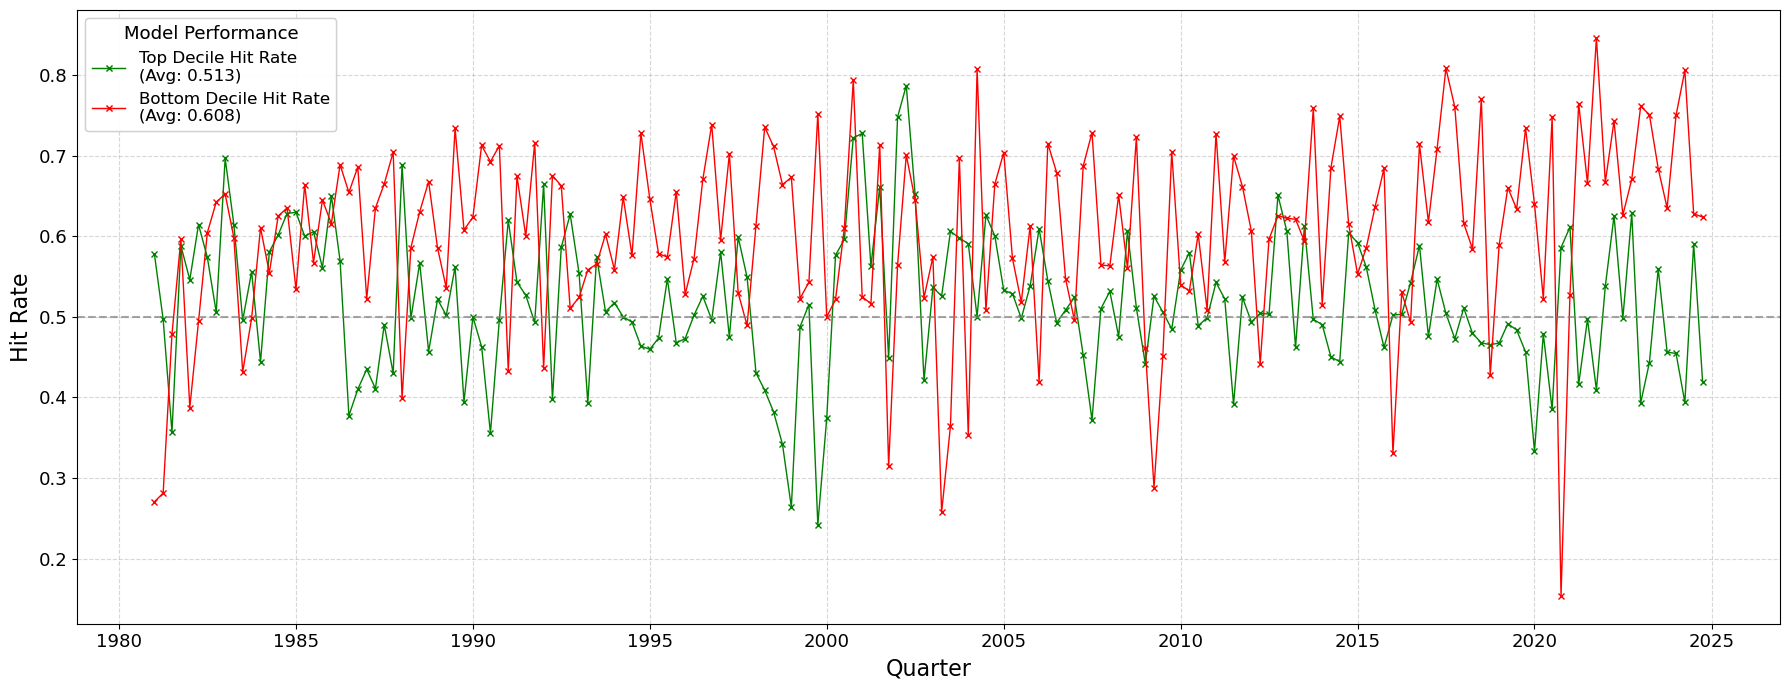

In [38]:
import pandas as pd
import matplotlib.pyplot as plt

preds = pd.read_csv("data/Amalgam_Top_Predictions.csv")
full_data = pd.read_csv('data_merged_pctfluidshiftpct.csv', usecols=['PERMNO', 'y', 'qtr', 'RET', 'vwretd'])

df = preds.merge(full_data, on=['PERMNO', 'y', 'qtr'], how='left')

df['rank'] = df.groupby(['y', 'qtr'])['prob'].rank(pct=True)
df['is_top_decile'] = df['rank'] >= 0.9
df['is_bottom_decile'] = df['rank'] <= 0.1

df['top_hit'] = df['is_top_decile'] & (df['RET'] > df['vwretd'])
df['bottom_hit'] = df['is_bottom_decile'] & (df['RET'] < df['vwretd'])

hit_stats = df.groupby(['y', 'qtr']).agg(
    top_n=('is_top_decile', 'sum'),
    top_hits=('top_hit', 'sum'),
    bottom_n=('is_bottom_decile', 'sum'),
    bottom_hits=('bottom_hit', 'sum')
).reset_index()

hit_stats['top_hit_rate'] = hit_stats['top_hits'] / hit_stats['top_n']
hit_stats['bottom_hit_rate'] = hit_stats['bottom_hits'] / hit_stats['bottom_n']

avg_top_hit = hit_stats['top_hits'].sum() / hit_stats['top_n'].sum()
avg_bottom_hit = hit_stats['bottom_hits'].sum() / hit_stats['bottom_n'].sum()

plt.figure(figsize=(18, 7))
x_vals = pd.to_datetime(hit_stats['y'].astype(str) + 'Q' + hit_stats['qtr'].astype(str))

top_line, = plt.plot(x_vals, hit_stats['top_hit_rate'], label='Top Decile Hit Rate', color='green', linewidth=1, marker='x', markersize=5)
bot_line, = plt.plot(x_vals, hit_stats['bottom_hit_rate'], label='Bottom Decile Hit Rate', color='red', linewidth=1, marker='x', markersize=5)

plt.axhline(0.5, linestyle='--', color='gray', alpha=0.7)

extra_legend = plt.legend(
    [top_line, bot_line],
    [f'Top Decile Hit Rate\n(Avg: {avg_top_hit:.3f})',
     f'Bottom Decile Hit Rate\n(Avg: {avg_bottom_hit:.3f})'],
    loc='upper left',
    fontsize=12,
    title="Model Performance",
    title_fontsize=13
)

plt.gca().add_artist(extra_legend)

#plt.title("Top & Bottom Decile Hit Rates Per Quarter", fontsize=18)
plt.xlabel("Quarter", fontsize=16)
plt.ylabel("Hit Rate", fontsize=16)
plt.xticks(fontsize=13)
plt.yticks(fontsize=13)
plt.grid(True, linestyle='--', alpha=0.5)
plt.tight_layout()
plt.show()

In [39]:
avg_top_hit = hit_stats['top_hits'].sum() / hit_stats['top_n'].sum()
avg_bottom_hit = hit_stats['bottom_hits'].sum() / hit_stats['bottom_n'].sum()

print(f"Average Top Decile Hit Rate: {avg_top_hit:.3f}")
print(f"Average Bottom Decile Hit Rate: {avg_bottom_hit:.3f}")

Average Top Decile Hit Rate: 0.513
Average Bottom Decile Hit Rate: 0.608


In [40]:
preds = pd.read_csv("data/Amalgam_Top_Predictions.csv")
full_data = pd.read_csv('data_merged_pctfluidshiftpct.csv', usecols=['PERMNO', 'y', 'qtr', 'RET', 'vwretd'])

df = preds.merge(full_data, on=['PERMNO', 'y', 'qtr'], how='left')

df['rank'] = df.groupby(['y', 'qtr'])['prob'].rank(pct=True)
df['is_top_decile'] = df['rank'] >= 0.9
df['is_bottom_decile'] = df['rank'] <= 0.1

# Subset: top and bottom decile
top_decile = df[df['is_top_decile']]
bottom_decile = df[df['is_bottom_decile']]

# Count positive vs negative RET
top_pos = (top_decile['RET'] > 0).sum()
top_neg = (top_decile['RET'] < 0).sum()
top_total = len(top_decile)

bottom_pos = (bottom_decile['RET'] > 0).sum()
bottom_neg = (bottom_decile['RET'] < 0).sum()
bottom_total = len(bottom_decile)

top_pos_ret = top_decile[top_decile['RET'] > 0]['RET'].median()
top_neg_ret = top_decile[top_decile['RET'] < 0]['RET'].median()

bottom_pos_ret = bottom_decile[bottom_decile['RET'] > 0]['RET'].median()
bottom_neg_ret = bottom_decile[bottom_decile['RET'] < 0]['RET'].median()

print("Top Decile:")
print(f"  Positive returns: {top_pos} ({top_pos / top_total:.1%})")
print(f"  Negative returns: {top_neg} ({top_neg / top_total:.1%})")
print(f"  Median Positive Return: {top_pos_ret:.3%}")
print(f"  Median Negative Return: {top_neg_ret:.3%}")

print("\nBottom Decile:")
print(f"  Positive returns: {bottom_pos} ({bottom_pos / bottom_total:.1%})")
print(f"  Negative returns: {bottom_neg} ({bottom_neg / bottom_total:.1%})")
print(f"  Median Positive Return: {bottom_pos_ret:.3%}")
print(f"  Median Negative Return: {bottom_neg_ret:.3%}")

summary_df = pd.DataFrame({
    "Decile": ["Top", "Bottom"],
    "Positive Count": [top_pos, bottom_pos],
    "Negative Count": [top_neg, bottom_neg],
    "Total Count": [top_total, bottom_total],
    "Positive %": [top_pos / top_total, bottom_pos / bottom_total],
    "Negative %": [top_neg / top_total, bottom_neg / bottom_total],
    "Median Positive Return": [top_pos_ret, bottom_pos_ret],
    "Median Negative Return": [top_neg_ret, bottom_neg_ret],
})

summary_df.to_csv("decile_return_summary.csv", index=False)

Top Decile:
  Positive returns: 45144 (59.7%)
  Negative returns: 30487 (40.3%)
  Median Positive Return: 11.993%
  Median Negative Return: -9.394%

Bottom Decile:
  Positive returns: 35460 (47.0%)
  Negative returns: 39963 (52.9%)
  Median Positive Return: 12.687%
  Median Negative Return: -17.391%


In [41]:
preds = pd.read_csv("data/Amalgam_Top_Predictions.csv")
full_data = pd.read_csv('data_merged_pctfluidshiftpct.csv', usecols=['PERMNO', 'y', 'qtr', 'RET', 'vwretd'])

df = preds.merge(full_data, on=['PERMNO', 'y', 'qtr'], how='left')

df['rank'] = df.groupby(['y', 'qtr'])['prob'].rank(pct=True)
df['is_top_decile'] = df['rank'] >= 0.9
df['is_bottom_decile'] = df['rank'] <= 0.1

top_decile = df[df['is_top_decile']]
bottom_decile = df[df['is_bottom_decile']]

top_pos = (top_decile['RET'] > 0).sum()
top_neg = (top_decile['RET'] < 0).sum()
top_total = len(top_decile)
top_pos_ret = top_decile[top_decile['RET'] > 0]['RET'].median()
top_neg_ret = top_decile[top_decile['RET'] < 0]['RET'].median()

bottom_pos = (bottom_decile['RET'] > 0).sum()
bottom_neg = (bottom_decile['RET'] < 0).sum()
bottom_total = len(bottom_decile)
bottom_pos_ret = bottom_decile[bottom_decile['RET'] > 0]['RET'].median()
bottom_neg_ret = bottom_decile[bottom_decile['RET'] < 0]['RET'].median()

summary_df = pd.DataFrame({
    "Decile": ["Top", "Bottom"],
    "Positive Count": [top_pos, bottom_pos],
    "Negative Count": [top_neg, bottom_neg],
    "Total Count": [top_total, bottom_total],
    "Positive %": [top_pos / top_total, bottom_pos / bottom_total],
    "Negative %": [top_neg / top_total, bottom_neg / bottom_total],
    "Median Positive Return": [top_pos_ret, bottom_pos_ret],
    "Median Negative Return": [top_neg_ret, bottom_neg_ret],
})

summary_df.to_csv("decile_return_summary.csv", index=False)

#### Average Industry Holdings for Top and Bottom Decile Portfolios

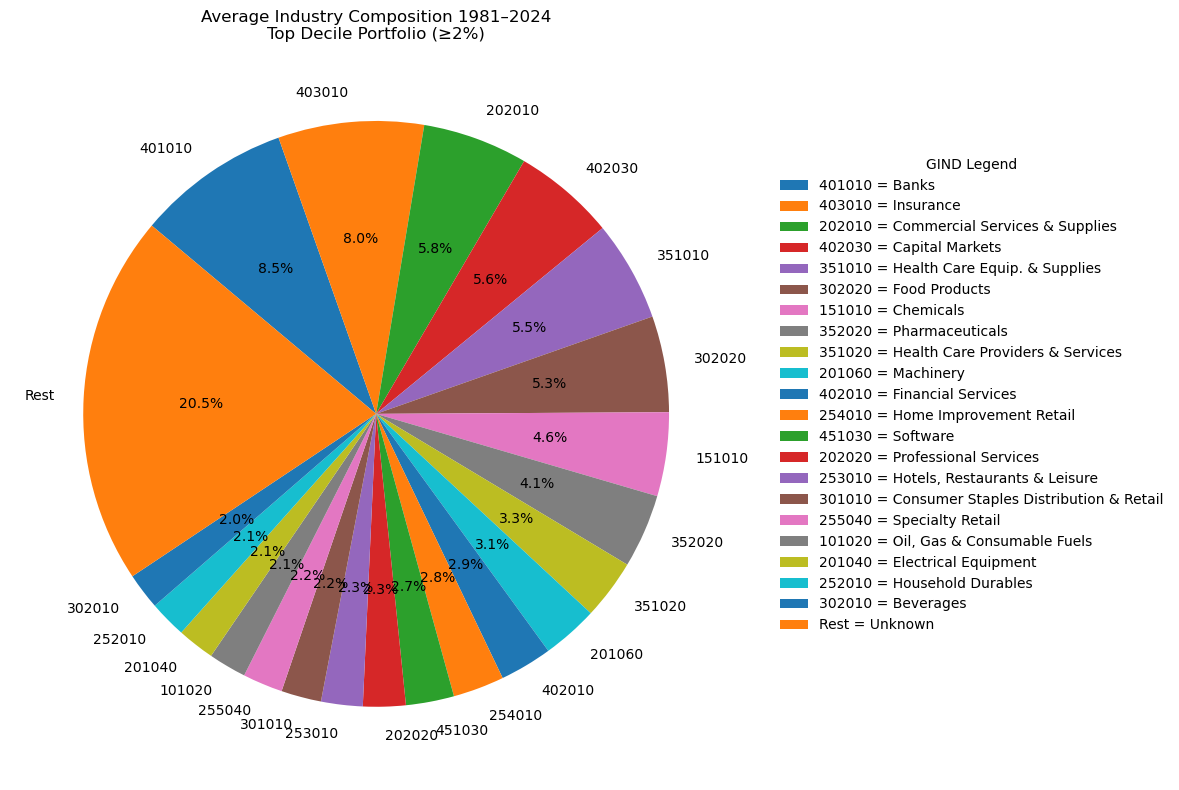

In [42]:
GIND_name_map = {
    "401010": "Banks",
    "403010": "Insurance",
    "451030": "Software",
    '402010': 'Financial Services',
    "101020": "Oil, Gas & Consumable Fuels",
    "351020": "Health Care Providers & Services",
    "402030": "Capital Markets",
    "255040": "Specialty Retail",
    '202020': 'Professional Services',
    "201060": "Machinery",
    '253010': 'Hotels, Restaurants & Leisure',
    '201040': 'Electrical Equipment',
    '252010': 'Household Durables',
    '254010': 'Home Improvement Retail',
    '301010': 'Consumer Staples Distribution & Retail',
    '302010': 'Beverages',
    "352020": "Pharmaceuticals",
    "351010": "Health Care Equip. & Supplies",
    "151010": "Chemicals",
    "202010": "Commercial Services & Supplies",
    "302020": "Food Products",
    "0": "Unlabeled at Time of Mapping",
    "Other": "All other industries (<2%)"
}

preds['GIND'] = preds['GIND'].astype(str)

preds['rank'] = preds.groupby(['y', 'qtr'])['prob'].rank(pct=True)
top_decile = preds[preds['rank'] >= 0.9].copy()

gind_counts = top_decile.groupby(['y', 'qtr', 'GIND']).size().unstack(fill_value=0)
avg_gind = gind_counts.mean().sort_values(ascending=False)

avg_gind_pct = 100 * avg_gind / avg_gind.sum()

# Filter for ≥2% and group the rest as "Other"
filtered = avg_gind_pct[avg_gind_pct >= 2]
other = avg_gind_pct[avg_gind_pct < 2].sum()
filtered["Rest"] = other

fig, ax = plt.subplots(figsize=(10, 8))
wedges, texts, autotexts = ax.pie(
    filtered.values,
    labels=filtered.index,
    autopct='%1.1f%%',
    startangle=140,
    counterclock=False
)

legend_labels = [f"{code} = {GIND_name_map.get(code, 'Unknown')}" for code in filtered.index]
fig.legend(wedges, legend_labels, title="GIND Legend", loc="center right", bbox_to_anchor=(1.3, 0.5), frameon=False)

ax.set_title("Average Industry Composition 1981–2024\nTop Decile Portfolio (≥2%)")
ax.set_ylabel("")

plt.tight_layout()
plt.show()

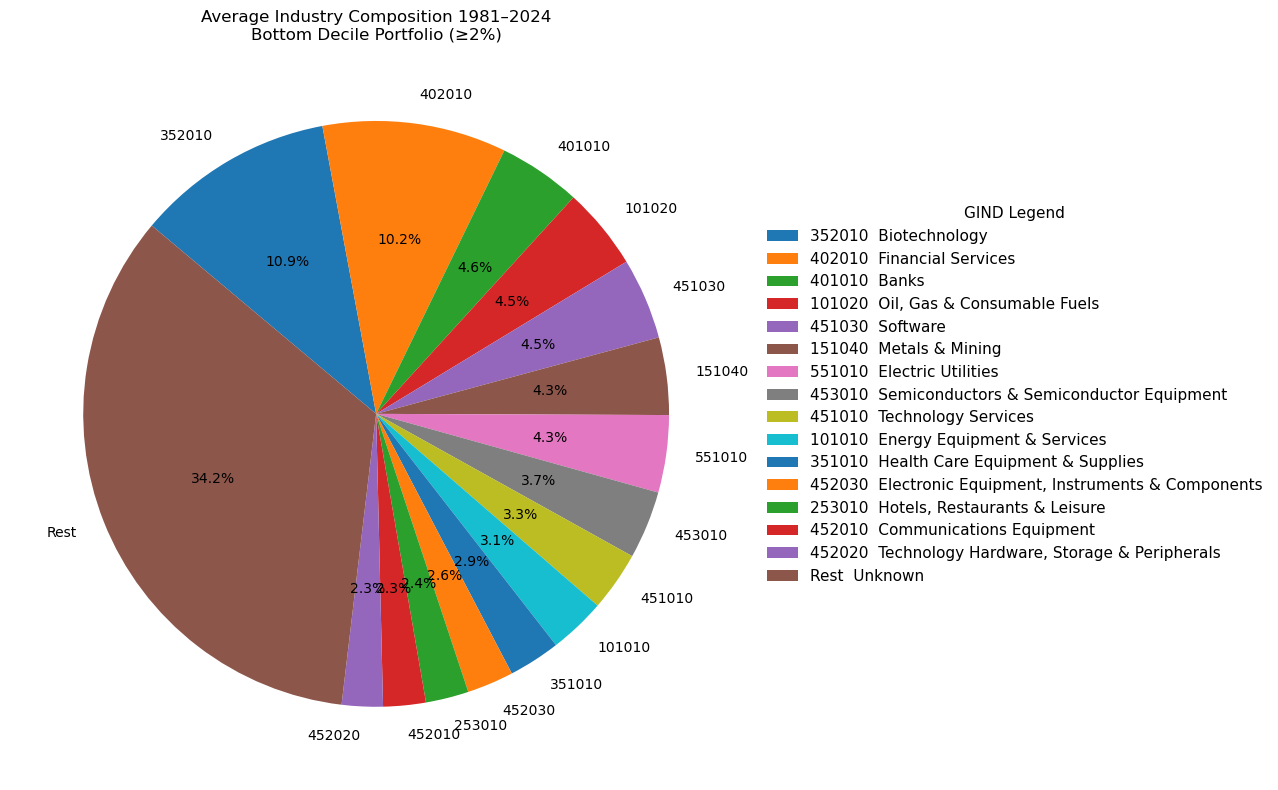

In [43]:
preds['GIND'] = preds['GIND'].astype(str)

preds['rank'] = preds.groupby(['y', 'qtr'])['prob'].rank(pct=True)
bottom_decile = preds[preds['rank'] <= 0.1].copy()

gind_counts = bottom_decile.groupby(['y', 'qtr', 'GIND']).size().unstack(fill_value=0)
avg_gind = gind_counts.mean().sort_values(ascending=False)

avg_gind_pct = 100 * avg_gind / avg_gind.sum()
filtered = avg_gind_pct[avg_gind_pct >= 2]
other = avg_gind_pct[avg_gind_pct < 2].sum()
filtered["Rest"] = other

gind_legend = {
    '352010': 'Biotechnology',
    '401010': 'Banks',
    '402010': 'Financial Services',
    '453010': 'Semiconductors & Semiconductor Equipment',
    '101010': 'Energy Equipment & Services',
    '451030': 'Software',
    '551010': 'Electric Utilities',
    '351010': 'Health Care Equipment & Supplies',
    '0': 'Unlabeled at Time of Mapping',
    '151040': 'Metals & Mining',
    '101020': 'Oil, Gas & Consumable Fuels',
    '452030': 'Electronic Equipment, Instruments & Components',
    '452010': 'Communications Equipment',
    '202010': 'Commercial Services & Supplies',
    '255040': 'Specialty Retail',
    '253010': 'Hotels, Restaurants & Leisure',
    '252010': 'Household Durables',
    '451010': 'Technology Services',
    '201060': 'Machinery',
    '403010': 'Insurance',
    '351020': 'Health Care Providers & Services',
    '452020': 'Technology Hardware, Storage & Peripherals',
    'Other': 'All other industries (<2%)'
}

fig, ax = plt.subplots(figsize=(10, 8))
wedges, texts, autotexts = ax.pie(
    filtered,
    labels=filtered.index,
    autopct='%1.1f%%',
    startangle=140,
    counterclock=False
)
ax.set_title("Average Industry Composition 1981–2024\nBottom Decile Portfolio (≥2%)")
ax.set_ylabel("")

legend_labels = [f"{gind}  {gind_legend.get(gind, 'Unknown')}" for gind in filtered.index]
fig.legend(
    wedges,
    legend_labels,
    title="GIND Legend",
    loc="center right",
    bbox_to_anchor=(1.4, 0.5),
    frameon=False,
    prop={'size': 11},       
    title_fontsize=11          
)

plt.tight_layout()
plt.show()